In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from tqdm import tqdm
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

In [16]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [24]:
def load_img(image_path, size=None):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    if size:
        img = tf.image.resize(img, size)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def gram_matrix(image):
    result = tf.linalg.einsum('bijc,bijd->bcd', image, image)
    input_shape = tf.shape(image)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def vgg_layers(layer_names):
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_content_loss(features_dict):
    style_features = features_dict['style']
    content_features = features_dict['content']
    style_loss = tf.add_n([tf.reduce_mean((style_features[name]-style_targets[name])**2) 
                           for name in style_features.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_features[name]-content_targets[name])**2) 
                             for name in content_features.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [25]:
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, image):
        img = image * 255.0
        img = preprocess_input(img)
        features = self.vgg(img)
        style_features, content_features = features[:self.num_style_layers], features[self.num_style_layers:]
        
        content_dict = {content_layer: value
                        for content_layer, value
                        in zip(self.content_layers, content_features)}

        style_gram = [gram_matrix(style_feature)
                        for style_feature in style_features]
        style_dict = {style_layer: value
                    for style_layer, value
                    in zip(self.style_layers, style_gram)}
        return {'content': content_dict, 'style': style_dict}

In [35]:
# Load Content Image
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_img(content_path)

# LOad Style Image
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_image = load_img(style_path, (256, 256))

100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


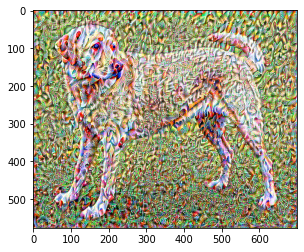

In [36]:
# Weigth
content_weight = 1e5
style_weight = 1e5
total_variation_weight = 3

# Epochs
epochs = 100

# Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Target Image
target_image = tf.Variable(content_image)

# Feature
extractor = StyleContentExtractor(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Train
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

for n in tqdm(range(epochs)):
    train_step(target_image)
plt.imshow(tensor_to_image(target_image))

In [31]:
# file_name = 'stylized-image.png'
# tensor_to_image(image).save(file_name)

# try:
#     from google.colab import files
# except ImportError:
#     pass
# else:
#     files.download(file_name)